# Naïve Bayes

This algorithm assigns a class $\hat{c}_k$ from all the possible classes in $\mathbf{C}$, to each $y_i$ in $\mathbf{Y}$ using the Bayes Theorem as follows:

$$
P\left(\mathbf{C}\,\middle|\,\{\mathbf{X}_j\}\right) = \frac{\mathcal{L}\left(\{\mathbf{X}_j\}\,\middle|\,\mathbf{C}\right) \times P\left(\mathbf{C}\right)}{P\left(\mathbf{X}_j\right)}
$$

where:

$P\left(\mathbf{C}\,\middle|\,\{\mathbf{X}_j\}\right)$ is the posterior probability distribution, that is, given the observed feature set $\{\mathbf{X}_j\}$.

$\mathcal{L}\left(\{\mathbf{X}_j\}\,\middle|\,\mathbf{C}\right)$ is the likelihood *function* (not distribution) which holds information on the probability of having observed the feature set $\{\mathbf{X}_j\}$ taking as ground truth the classes $\mathbf{C}$.

$P\left(\mathbf{C}\right)$ is the prior probability distribution of $\mathbf{C}$, that is, the probability of each class in the absence of any observation in the feature set.

$P\left(\mathbf{X}_j\right)$ this is the posterior probability distribution integrated over all classes. It is also called the evidence.

Thus, given a set of features $\{\mathbf{X}_j\}$ and our pejudices about the possible classes $\mathbf{C}$, this algorithm seeks the maximum of the posterior probability that assigns the class $\hat{c}_k$ to the set $\{\mathbf{X}_j\}$.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.feature_selection import mutual_info_regression

sns.set(context="notebook", style="darkgrid", palette="muted", color_codes=True)

In [2]:
def data_split(dataset, ratio=0.9):
    """Splits the given dataset in the given ratio.
    
    Given a dataset and a ratio this function returns
    two datasets representing the first fraction of the
    dataset row-wise and the complementary subset.
    """
    N = dataset.shape[0]
    S = int(N*ratio)
    subset_1, subset_2 = dataset[:S], dataset[S:]
    return subset_1, subset_2

def remove_columns(dataset, in_strings, inplace=False):
    """Removes the given columns from the dataset
    
    Given a dataset and a set of columns, this function
    returns a dataset without those columns. If inplace
    is True, returns None and the given dataset will be
    modified.
    """
    to_remove = [column for column in dataset.columns for _str in in_strings if _str in column]
    return dataset.drop(columns=to_remove, inplace=inplace)

def normalize_metadata(dataset, inplace=False):
    if inplace:
        ds = dataset
    else:
        ds = dataset.copy()
    
    ds.index = pd.to_datetime(ds.index)
    ds.columns = map(lambda name: name.lower(), ds.columns)
    ds.index.name = ds.index.name.lower()
    return None if inplace else ds

In [3]:
for_training = pd.read_csv("../data/raw/sp500-for-training.csv", index_col="Date")
normalize_metadata(for_training, inplace=True)

for_prediction = pd.read_csv("../data/raw/sp500-for-prediction.csv", index_col="Date")
normalize_metadata(for_prediction, inplace=True)

sp500 = for_training["gspc.close"]
sp500_prediction = for_prediction["gspc.close"]

s1, s2 = set(for_training.columns), set(for_prediction.columns)
s = list(s1.intersection(s2))

for_training = for_training.filter(items=s, axis=1)
for_prediction = for_prediction.filter(items=s, axis=1)

In [4]:
# binarize class column
Y = for_training["class"].apply(lambda x: 1 if x=="UP" else -1)
X = for_training.drop(columns="class")
# remove_columns(X, "year month day gspc roc mom lag volume".split(), inplace=True)
# implement data normalization
X_norm = X.apply(preprocessing.scale)
# implement filtering of features
mi = mutual_info_regression(X_norm, Y)
X_norm = X_norm[X_norm.columns[mi>np.percentile(mi, 95)]]
# implement data splitting
X_train, X_test = data_split(X_norm, ratio=0.8)
Y_train, Y_test = data_split(Y, ratio=0.8)
sp500_train, sp500_test = data_split(sp500, ratio=0.8)
# implement model training
nbg = GaussianNB()
nbg.fit(X_train, Y_train)
# implement model testing
Y_pred = nbg.predict(X_test)
# implement model evaluation
accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
model_eval = pd.Series(data=[accuracy, precision, recall], index="Accuracy Precision Recall".split(), name="Model Evaluation")
model_eval

/home/mejia/Projects/CBT/env/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/mejia/Projects/CBT/env/lib/python2.7/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


Accuracy     0.817416
Precision    0.792056
Recall       0.892105
Name: Model Evaluation, dtype: float64

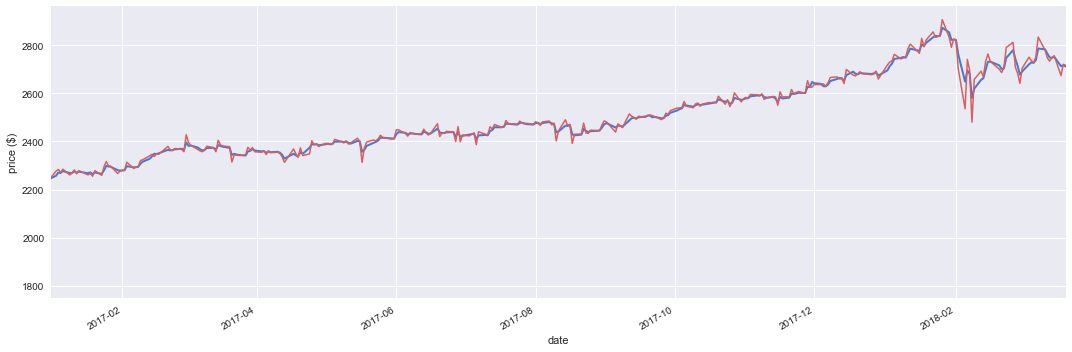

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

sp500_test.plot(lw=2.0)

delta_y = abs(sp500_test.diff())
y = sp500_test
price_pred = Y_pred*delta_y + y

ax.plot(X_test.index, price_pred, lw=1.5, color="r")
ax.set_xlim(pd.date_range("2017-01-01", X_test.index[-1]).date[[0,-1]])
ax.set_ylabel(r"price ($)")
fig.tight_layout()

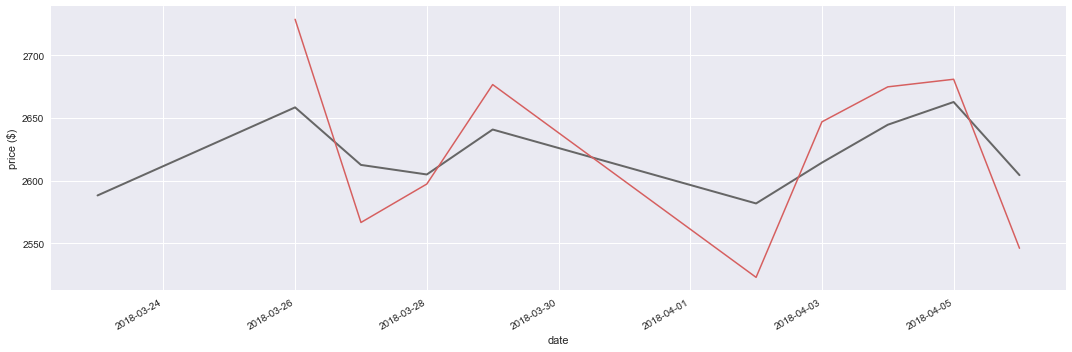

In [6]:
X_prediction = for_prediction.drop(columns="class")
X_prediction = X_prediction.apply(preprocessing.scale)
# remove_columns(X_prediction, "year month day gspc roc mom lag volume".split(), inplace=True)
X_prediction = X_prediction[X_prediction.columns[mi>np.percentile(mi, 95)]]

Y_prediction = nbg.predict(X_prediction)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

sp500_prediction.plot(lw=2.0, color="0.4")

delta_y = abs(sp500_prediction.diff())
y = sp500_prediction
price_pred = Y_prediction*delta_y + y

ax.plot(X_prediction.index, price_pred, lw=1.5, color="r")
ax.set_ylabel(r"price ($)")
fig.tight_layout()